In [442]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns

from collections import Counter

In [443]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train_ID = train['Id']
test_ID = test['Id']

train = train.drop(['Id'], axis=1)
test = test.drop(['Id'], axis=1)

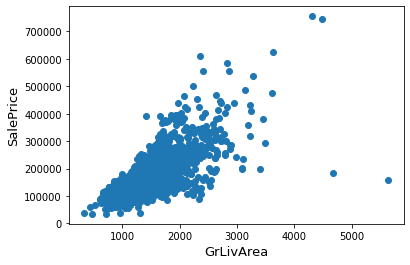

In [444]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Уберем выбросы

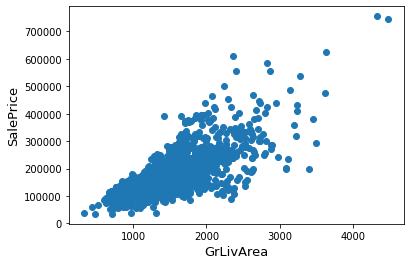

In [445]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [446]:
ntrain = train.shape[0]
ntest = test.shape[0]
train_prices = train.SalePrice.values
train["SalePrice"] = np.log1p(train["SalePrice"])
y_train = train.SalePrice.values

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

Посмотрим на пропущенные данные

In [447]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(10)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageYrBlt,5.450806
GarageQual,5.450806
GarageCond,5.450806


Удалим первые 4 признака, т.к. там пропущено значительное количество данных

In [448]:
all_data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)

Также удалим Utilities, т.к. больше 99% строк имеют одно значение, другие признаки аналогично.

In [449]:
all_data = all_data.drop(['Utilities', 'Street', 'Condition2', 'RoofMatl', 'Heating', 'Electrical', 
                          'SaleType'], axis=1)

Заменим пропущенные значения


In [450]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

Добавим новый признак -- общая площадь 

In [451]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [452]:
cat_features = ['MSSubClass', 'MSZoning','LotShape', 'LandContour', 'LotConfig',
'LandSlope', 'Neighborhood', 'Condition1','BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC','CentralAir',
'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual','GarageCond',
'PavedDrive', 'SaleCondition']

num_features = list(set(list(all_data.columns)) - set(cat_features))

Поправляем редкие значения

In [453]:
all_data.loc[all_data['RoofStyle'] == 'Shed', ['RoofStyle']] = 'Mansard'

all_data.loc[(all_data['Exterior1st'] == 'BrkComm') | (all_data['Exterior1st'] == 'AsphShn') |\
             (all_data['Exterior1st'] == 'CBlock'), ['Exterior1st']] = 'AsbShng'
all_data.loc[(all_data['Exterior1st'] == 'Stone') | (all_data['Exterior1st'] == 'ImStucc'), ['Exterior1st']] = 'WdShing'

all_data.loc[(all_data['Exterior2nd'] == 'AsphShn') | (all_data['Exterior2nd'] == 'CBlock') | \
             (all_data['Exterior2nd'] == 'Stone') | (all_data['Exterior2nd'] == 'Stocco'), ['Exterior2nd']] = 'Stucco'
all_data.loc[(all_data['Exterior2nd'] == 'Other'), ['Exterior2nd']] = 'VinylSd'
all_data.loc[(all_data['Exterior2nd'] == 'Brk Cmn'), ['Exterior2nd']] = 'BrkFace'

all_data.loc[all_data['ExterQual'] == 'Po', ['ExterQual']] = 'Fa'

all_data.loc[all_data['ExterCond'] == 'Ex', ['ExterCond']] = 'Gd'
all_data.loc[all_data['ExterCond'] == 'Po', ['ExterCond']] = 'Fa'

all_data.loc[all_data['BsmtCond'] == 'Po', ['BsmtCond']] = 'Fa'

all_data.loc[all_data['HeatingQC'] == 'Po', ['HeatingQC']] = 'Fa'

all_data.loc[(all_data['Functional'] == 'Sev') | (all_data['Functional'] == 'Maj2'), ['Functional']] = 'Maj1'

all_data.loc[all_data['FireplaceQu'] == 'Po', ['FireplaceQu']] = 'Fa'

all_data.loc[all_data['GarageType'] == '2Types', ['GarageType']] = 'Basment'
all_data.loc[all_data['GarageType'] == 'CarPort', ['GarageType']] = 'BuiltIn'

all_data.loc[all_data['GarageQual'] == 'Ex', ['GarageQual']] = 'Gd'
all_data.loc[all_data['GarageQual'] == 'Po', ['GarageQual']] = 'Fa'
all_data.loc[all_data['GarageCond'] == 'Ex', ['GarageCond']] = 'Gd'
all_data.loc[all_data['GarageCond'] == 'Po', ['GarageCond']] = 'Fa'

all_data.loc[(all_data['SaleCondition'] == 'AdjLand') | (all_data['SaleCondition'] == 'Alloca'), ['SaleCondition']] = 'Family'

Закодируем категориальные признаки

Отмасштабируем числовые

In [454]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
for c in cat_features:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))
    
for c in num_features:
    scaler = MinMaxScaler()
    scaler.fit(all_data[c].values.reshape(-1, 1)) 
    all_data[c] = scaler.transform(all_data[c].values.reshape(-1, 1))

In [455]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, SGDRegressor
from sklearn.model_selection import GridSearchCV

train = all_data[:ntrain]
test = all_data[ntrain:]

In [456]:
def rmsle_cv(model, n_folds):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    
    return(rmse)

P.s. параметры подбирал вручную по сетке

In [457]:
lasso = Lasso(alpha=2.15443469e-04)
KRR = KernelRidge(alpha=0.37926901907322497, kernel='polynomial', degree=2, coef0=25)
e_net = ElasticNet(alpha=0.0002, l1_ratio=.5, random_state=3)

print('lasso score:{}'.format(rmsle_cv(lasso,5).mean()))
print('KRR score:{}'.format(rmsle_cv(KRR,5).mean()))
print('e_net score:{}'.format(rmsle_cv(e_net,5).mean()))

lasso score:0.12142257335186306
KRR score:0.12306524525438353
e_net score:0.12139838113490417


In [458]:
lasso.fit(train, y_train)
lasso_predictions = np.expm1(lasso.predict(test))

KRR.fit(train, y_train)
KRR_predictions = np.expm1(KRR.predict(test))

e_net.fit(train, y_train)
e_net_predictions = np.expm1(e_net.predict(test))

In [459]:
all_together = 0.45*KRR_predictions + 0.3*lasso_predictions + 0.25*e_net_predictions

In [441]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = all_together
sub.to_csv('submission.csv',index=False)